In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection  import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict

In [5]:
train_dataset=pd.read_csv('./train.csv', header=0)
test_dataset=pd.read_csv('./test.csv', header=0)

In [6]:
categorical_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                     'MiscFeature','SaleType','SaleCondition']
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
train_dataset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [39]:
train_dataset.shape

(1460, 270)

In [7]:
every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features and col not in ['Id'] ]

#log transform skewed numeric features:
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index

#skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index

train_dataset[numeric_feats] = np.log1p(train_dataset[numeric_feats])

every_column_non_categorical= [col for col in test_dataset.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = test_dataset[every_column_non_categorical].dtypes[test_dataset.dtypes != "object"].index
test_dataset[numeric_feats] = np.log1p(test_dataset[numeric_feats])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log1p
  # Remove the CWD from sys.path while we load stuff.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


In [8]:
features_with_nan=['Alley','MasVnrType','BsmtQual','BsmtQual','BsmtCond','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']
#function that creates a column for every value it might have
def ConverNaNToNAString(data, columnList):
    for x in columnList:       
        data[x] =str(data[x])              
            

ConverNaNToNAString(train_dataset, features_with_nan)
ConverNaNToNAString(test_dataset, features_with_nan)

In [9]:
#function that creates a column for every value it might have
def CreateColumnPerValue(data, columnList):
    for x in columnList:

        values=pd.unique(data[x])
        
        for v in values:
            column_name=x+"_"+str(v)   
            data[column_name]=(data[x]==v).astype(float)
    
        data.drop(x, axis=1, inplace=True)
        

In [10]:
train_dataset = pd.get_dummies(train_dataset,columns =categorical_features)
test_dataset = pd.get_dummies(test_dataset,columns =categorical_features)

In [21]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 booster='gbtree',
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [22]:
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
model.fit(train_dataset[every_column_except_y],train_dataset['SalePrice'])



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method=None, validate_parameters=False, verbosity=None)

<BarContainer object of 268 artists>

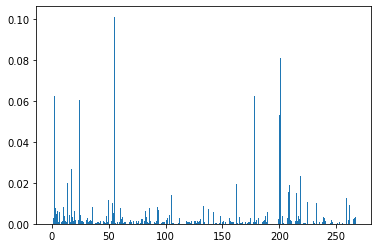

In [30]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [28]:
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 2574),
             ('LotFrontage', 2397),
             ('BsmtUnfSF', 2220),
             ('GrLivArea', 2175),
             ('TotalBsmtSF', 1902),
             ('GarageYrBlt', 1869),
             ('1stFlrSF', 1854),
             ('GarageArea', 1752),
             ('WoodDeckSF', 1443),
             ('OpenPorchSF', 1442),
             ('BsmtFinSF1', 1412),
             ('MasVnrArea', 1315),
             ('YearBuilt', 1278),
             ('MoSold', 1190),
             ('YearRemodAdd', 1068),
             ('2ndFlrSF', 1037),
             ('OverallCond', 693),
             ('YrSold', 677),
             ('OverallQual', 584),
             ('EnclosedPorch', 525),
             ('TotRmsAbvGrd', 487),
             ('BsmtFinSF2', 427),
             ('BedroomAbvGr', 389),
             ('ScreenPorch', 346),
             ('Neighborhood_NAmes', 283),
             ('Fireplaces', 266),
             ('BsmtFullBath', 230),
             ('SaleCondition_Normal', 220),
             (

In [33]:
#Let's remove the less important ones 
most_relevant_features= list( dict((k, v) for k, v in model.get_booster().get_fscore().items() if v >= 100).keys())
print(most_relevant_features)

['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'FullBath', 'GarageCars', 'YearRemodAdd', 'OverallCond', 'GarageArea', 'MSZoning_RL', 'TotRmsAbvGrd', 'MSZoning_C (all)', 'MSZoning_RM', 'Fireplaces', 'BsmtFinSF1', '1stFlrSF', 'GarageYrBlt', 'LotArea', '2ndFlrSF', 'SaleCondition_Abnorml', 'OpenPorchSF', 'BldgType_1Fam', 'KitchenQual_Gd', 'Electrical_SBrkr', 'Neighborhood_Edwards', 'BsmtUnfSF', 'MoSold', 'Functional_Typ', 'LotFrontage', 'WoodDeckSF', 'HeatingQC_Ex', 'Fence_GdWo', 'Exterior2nd_Wd Sdng', 'LandContour_Bnk', 'HalfBath', 'BsmtFullBath', 'HeatingQC_TA', 'Condition1_Norm', 'Neighborhood_NAmes', 'SaleCondition_Family', 'YrSold', 'Exterior1st_VinylSd', 'LotShape_Reg', 'RoofStyle_Gable', 'BsmtFinSF2', 'MasVnrArea', 'Neighborhood_CollgCr', 'ScreenPorch', 'SaleCondition_Normal', 'LandContour_Lvl', 'HouseStyle_1.5Fin', 'HouseStyle_1Story', 'BsmtHalfBath', 'Exterior2nd_HdBoard', 'Fence_MnPrv', 'ExterCond_TA', 'LotConfig_Corner', 'Exterior1st_HdBoard', 'Exterior2nd_VinylSd', 'L

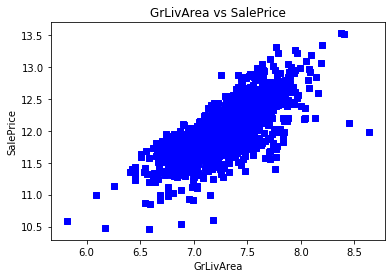

In [34]:
plt.scatter(train_dataset.GrLivArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

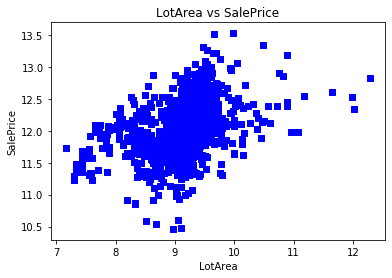

In [35]:
plt.scatter(train_dataset.LotArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("LotArea vs SalePrice")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [36]:
train_x=train_dataset[most_relevant_features]
train_y=train_dataset['SalePrice']

#for tuning parameters
#parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
#}

                    
#xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(train_x,train_y)
#print (gsearch1.grid_scores_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)

best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method=None, validate_parameters=False, verbosity=None)

### predict for test data and generate submission file

In [37]:
test_dataset['Prediction'] = np.expm1(best_xgb_model.predict(test_dataset[most_relevant_features]))
filename = 'submission.csv'
pd.DataFrame({'Id': test_dataset.Id, 'SalePrice': test_dataset.Prediction}).to_csv(filename, index=False)

In [38]:
print(test_dataset['Prediction'].head())
print(test_dataset['Prediction'].count())

0    119299.937500
1    161134.015625
2    198000.453125
3    193360.093750
4    183965.515625
Name: Prediction, dtype: float32
1459
